<a href="https://colab.research.google.com/github/boiBASH/Elite-Bank-Project/blob/main/Data_Transformation_and_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install mlflow
!pip install pyngrok
!pip install catboost
!pip install xgboost
!pip install shap

In [ ]:
#Import the necessary libraries
import os
import pandas as pd
import numpy as np
import mlflow
import matplotlib.pyplot as plt
import shap
import subprocess
from pyngrok import ngrok, conf
import getpass
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mlflow.models.signature import infer_signature
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [ ]:
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", MLFLOW_TRACKING_URI])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', 'sqli...>

In [ ]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [ ]:
token = os.getenv("NGROK_AUTH_TOKEN", "dummy_token")
conf.get_default().auth_token = token

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········
 * ngrok tunnel "https://538d-35-222-86-254.ngrok-free.app" -> "http://127.0.0.1:5000"


In [ ]:
df = pd.read_csv("datasets/Bank_Marketing_Dataset.csv")

In [ ]:
# Select the column types
scale_columns = [
    "age",
    "balance",
    "day",
    "duration"
]

categorical_columns = df.select_dtypes(include = ["object"]).columns.tolist()
categorical_columns.remove("deposit")

In [ ]:
# Extract features and labels from dataset
X, y = df.drop(labels = ["deposit"], axis = 1), df["deposit"]

In [ ]:
# Encode labels
map_dictionary = {
    "yes": 1,
    "no": 0
}

y = y.apply(lambda x: map_dictionary[x])

In [ ]:
# Separate into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y)

In [ ]:
# Implement data preparation transformer
def get_transformer(categorical_columns, scale_columns, one_hot=False):
    if one_hot:
        transformer = ColumnTransformer(
            transformers=[
                ("ord", OneHotEncoder(), categorical_columns),
                ("scale", StandardScaler(), scale_columns)
            ],
            remainder="passthrough"
        )
    else:
        transformer = ColumnTransformer(
            transformers=[
                ("ord", OrdinalEncoder(), categorical_columns),
                ("scale", StandardScaler(), scale_columns)
            ],
            remainder="passthrough"
        )
    return transformer

In [ ]:
def transform_data(df, transformer):
    """
    Fit and transform the DataFrame using the provided transformer.
    Returns a DataFrame with the appropriate feature names.
    """
    transformer.fit(df)
    transformed_array = transformer.transform(df)
    try:
        feature_names = transformer.get_feature_names_out()
    except AttributeError:
        feature_names = [f"feature_{i}" for i in range(transformed_array.shape[1])]
    return pd.DataFrame(transformed_array, columns=feature_names)

In [ ]:
# Logistic Regression pipeline using one-hot encoding for categorical variables
lr_pipe = Pipeline(
    steps=[
        ("1", get_transformer(categorical_columns, scale_columns, one_hot=True)),
        ("2", LogisticRegression(max_iter=1000))
    ]
)

# CatBoost pipeline using ordinal encoding for categorical variables
cat_pipe = Pipeline(
    steps=[
        ("1", get_transformer(categorical_columns, scale_columns, one_hot=False)),
        ("2", CatBoostClassifier())
    ]
)

# ExtraTrees pipeline using ordinal encoding for categorical variables
xgb_pipe = Pipeline(
    steps=[
        ("1", get_transformer(categorical_columns, scale_columns, one_hot=False)),
        ("2", XGBClassifier())
    ]
)

In [ ]:
# Fit LogisticRegression Model
lr_pipe.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord', OneHotEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('scale', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration'])])),
                ('2', LogisticRegression(max_iter=1000))])

In [ ]:
# Fit CatBoost model
cat_pipe.fit(X_train, y_train)

Learning rate set to 0.026238
0:	learn: 0.6782708	total: 50.9ms	remaining: 50.9s
1:	learn: 0.6653446	total: 54.7ms	remaining: 27.3s
2:	learn: 0.6537530	total: 58.4ms	remaining: 19.4s
3:	learn: 0.6398588	total: 62ms	remaining: 15.4s
4:	learn: 0.6273476	total: 65.7ms	remaining: 13.1s
5:	learn: 0.6151607	total: 69.6ms	remaining: 11.5s
6:	learn: 0.6041554	total: 73.3ms	remaining: 10.4s
7:	learn: 0.5933820	total: 77ms	remaining: 9.55s
8:	learn: 0.5845692	total: 80.9ms	remaining: 8.9s
9:	learn: 0.5765199	total: 84.6ms	remaining: 8.38s
10:	learn: 0.5678632	total: 88.7ms	remaining: 7.97s
11:	learn: 0.5599594	total: 92.7ms	remaining: 7.63s
12:	learn: 0.5532440	total: 96.7ms	remaining: 7.34s
13:	learn: 0.5465314	total: 101ms	remaining: 7.08s
14:	learn: 0.5401046	total: 104ms	remaining: 6.86s
15:	learn: 0.5335429	total: 108ms	remaining: 6.66s
16:	learn: 0.5276468	total: 112ms	remaining: 6.49s
17:	learn: 0.5221733	total: 116ms	remaining: 6.33s
18:	learn: 0.5167362	total: 120ms	remaining: 6.18s
19:

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord', OrdinalEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('scale', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration'])])),
                ('2',
                 <catboost.core.CatBoostClassifier object at 0x7b2354dd08d0>)])

In [ ]:
# Fit Xgboost model
xgb_pipe.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord', OrdinalEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('scale', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration'])])),
                ('2',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_b...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
def train_and_log_pipeline(pipeline, model_name, preprocess_name="1", model_step="2"):
    with mlflow.start_run(run_name=model_name):
        # Train the pipeline
        pipeline.fit(X_train, y_train)

        # Predictions on raw (untransformed) data
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]

        # Compute evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)

        # Compute specificity
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else None

        # --- Use Option 2: Infer model signature from raw input ---
        signature = infer_signature(X_test, y_pred)
        mlflow.sklearn.log_model(pipeline, model_name, signature=signature)

        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)
        if specificity is not None:
            mlflow.log_metric("specificity", specificity)

        # --- SHAP Explainability ---
        try:
            # Extract the model from the pipeline
            model = pipeline.named_steps[model_step]

            # Transform data for SHAP using the transformer step
            X_train_transformed = pipeline.named_steps[preprocess_name].transform(X_train)
            X_test_transformed = pipeline.named_steps[preprocess_name].transform(X_test)
            try:
                feature_names = pipeline.named_steps[preprocess_name].get_feature_names_out()
            except AttributeError:
                feature_names = [f"feature_{i}" for i in range(X_test_transformed.shape[1])]
            X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)

            # Compute SHAP values
            explainer = shap.Explainer(model, X_train_transformed)
            shap_values = explainer(X_test_transformed)
            shap_values_array = shap_values.values

            # SHAP Summary Plot
            shap.summary_plot(shap_values_array, X_test_transformed, show=False)
            summary_fig = plt.gcf()  # Get the current figure created by shap
            summary_fig.set_size_inches(10, 6)
            summary_plot_path = f"{model_name}_shap_summary.png"
            summary_fig.savefig(summary_plot_path, bbox_inches="tight")
            mlflow.log_artifact(summary_plot_path)
            plt.close(summary_fig)

            # SHAP Dependence Plots for Top 3 Features
            top_features = X_test_transformed.columns[:3]
            for feature in top_features:
                shap.dependence_plot(feature, shap_values_array, X_test_transformed, show=False)
                dep_fig = plt.gcf()
                dep_fig.set_size_inches(10, 6)
                dep_plot_path = f"{model_name}_shap_dependence_{feature}.png"
                dep_fig.savefig(dep_plot_path, bbox_inches="tight")
                mlflow.log_artifact(dep_plot_path)
                plt.close(dep_fig)

            print(f"✅ SHAP explanations logged for {model_name}")

        except Exception as e:
            print(f"⚠️ SHAP logging failed for {model_name}: {e}")

        print(f"✅ Model {model_name} logged successfully in MLflow!")

## --- Set up MLflow Experiment ---

In [ ]:
mlflow.set_experiment("Long-Term Investor Prediction")

<Experiment: artifact_location='/content/mlruns/1', creation_time=1741721440717, experiment_id='1', last_update_time=1741721440717, lifecycle_stage='active', name='Long-Term Investor Prediction', tags={}>

## --- Run the Pipelines ---

/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


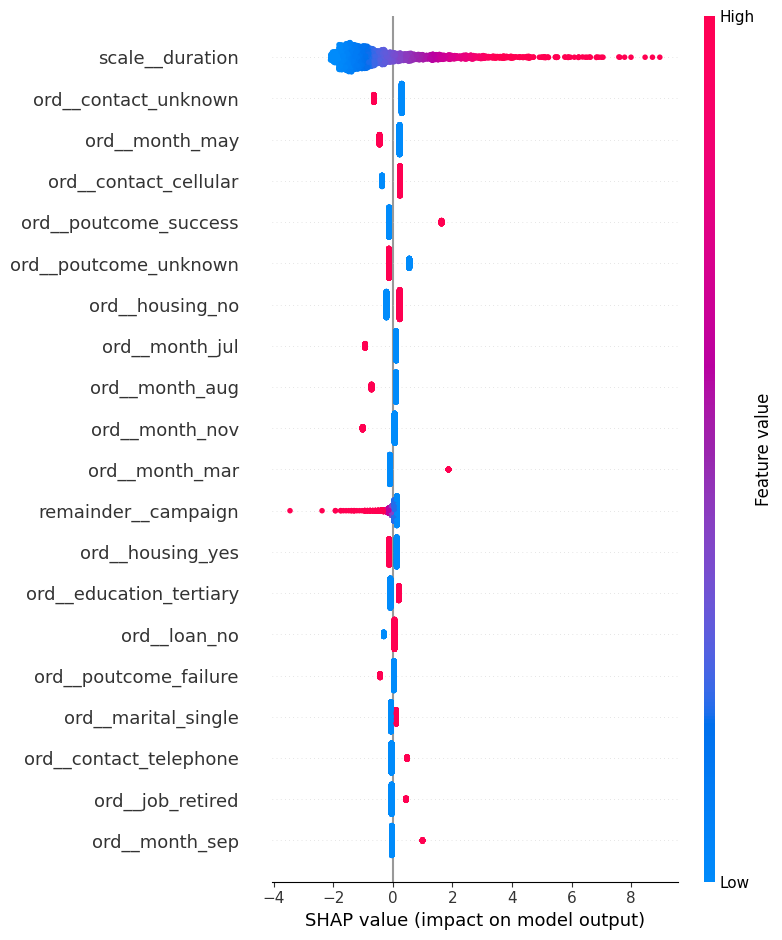

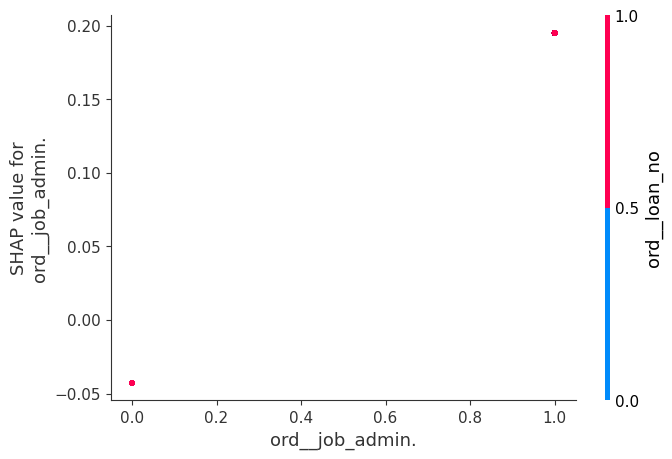

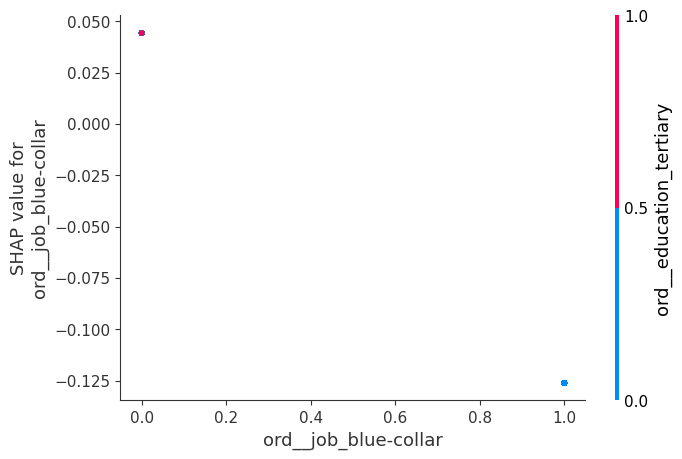

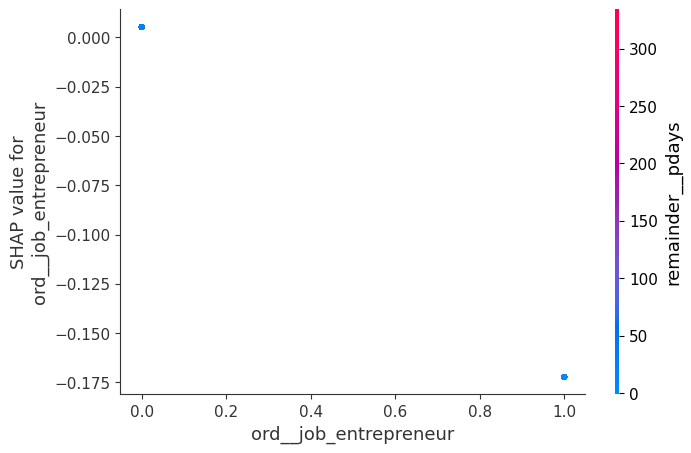

✅ SHAP explanations logged for LogisticRegression
✅ Model LogisticRegression logged successfully in MLflow!


In [ ]:
train_and_log_pipeline(lr_pipe, "LogisticRegression", preprocess_name="1", model_step="2")

In [ ]:
train_and_log_pipeline(cat_pipe, "CatBoost", preprocess_name="1", model_step="2")

Learning rate set to 0.026238
0:	learn: 0.6782708	total: 5.26ms	remaining: 5.25s
1:	learn: 0.6653446	total: 9.11ms	remaining: 4.54s
2:	learn: 0.6537530	total: 13.1ms	remaining: 4.35s
3:	learn: 0.6398588	total: 17.1ms	remaining: 4.26s
4:	learn: 0.6273476	total: 21.4ms	remaining: 4.25s
5:	learn: 0.6151607	total: 25.6ms	remaining: 4.24s
6:	learn: 0.6041554	total: 29.7ms	remaining: 4.21s
7:	learn: 0.5933820	total: 33.3ms	remaining: 4.13s
8:	learn: 0.5845692	total: 37.2ms	remaining: 4.09s
9:	learn: 0.5765199	total: 41.1ms	remaining: 4.07s
10:	learn: 0.5678632	total: 45ms	remaining: 4.05s
11:	learn: 0.5599594	total: 49.1ms	remaining: 4.04s
12:	learn: 0.5532440	total: 52.7ms	remaining: 4s
13:	learn: 0.5465314	total: 56.8ms	remaining: 4s
14:	learn: 0.5401046	total: 60.8ms	remaining: 3.99s
15:	learn: 0.5335429	total: 65ms	remaining: 4s
16:	learn: 0.5276468	total: 69ms	remaining: 3.99s
17:	learn: 0.5221733	total: 73.7ms	remaining: 4.02s
18:	learn: 0.5167362	total: 78.6ms	remaining: 4.06s
19:	lea

/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
100%|===================| 2223/2233 [02:16<00:00]       

✅ SHAP explanations logged for CatBoost
✅ Model CatBoost logged successfully in MLflow!


In [ ]:
train_and_log_pipeline(xgb_pipe, "XGBoost", preprocess_name="1", model_step="2")

/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
 96%|=================== | 2140/2233 [00:11<00:00]       

✅ SHAP explanations logged for XGBoost
✅ Model XGBoost logged successfully in MLflow!
